## Importing libraries

In [36]:
from torch.utils.data import DataLoader, Sampler, SubsetRandomSampler
from torch.utils.data import Dataset
from PIL import Image
from PIL import ImageFile
from tqdm import tqdm  
import torch
from collections import Counter
from torch.utils.data import ConcatDataset
import random
import os
import torchvision.transforms as transforms
import pandas as pd

# Allow loading of truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

## Creating dataset for multiple parts

In [37]:
# Define file paths as constants
CSV_FILE_PATH = r'C:\Users\Sandhra George\avalanche\data\dataset.csv'
ROOT_DIR_PATH = r'C:\Users\Sandhra George\avalanche\caxton_dataset'  # Common parent directory
root_dir = ROOT_DIR_PATH

# Load data into a DataFrame for easier processing
data = pd.read_csv(CSV_FILE_PATH)

# Filter the dataset to include images containing "print24", "print131", or "print0"
pattern = 'print24|print131|print0|print46|print82|print109|print111|print132|print171'
data_filtered = data[data.iloc[:, 0].str.contains(pattern, na=False)]

# Update the first column to include both the print folder and the image filename.
# The regex now captures the folder name (print24, print131, or print0) and the image filename.
data_filtered.iloc[:, 0] = data_filtered.iloc[:, 0].str.replace(
    r'.*?/(print24|print131|print0|print46|print82|print109|print111|print132|print171)/(image-\d+\.jpg)', 
    r'\1/\2', 
    regex=True
)

# Display the updated DataFrame
print("First rows of filtered DataFrame:")
print(data_filtered.head())

print("\nLast rows of filtered DataFrame:")
print(data_filtered.tail())

First rows of filtered DataFrame:
              img_path               timestamp  flow_rate  feed_rate  \
0   print0/image-6.jpg  2020-10-08T13:12:50-34        100        100   
1   print0/image-7.jpg  2020-10-08T13:12:50-80        100        100   
2   print0/image-8.jpg  2020-10-08T13:12:51-27        100        100   
3   print0/image-9.jpg  2020-10-08T13:12:51-74        100        100   
4  print0/image-10.jpg  2020-10-08T13:12:52-20        100        100   

   z_offset  target_hotend  hotend    bed  nozzle_tip_x  nozzle_tip_y  \
0       0.0          205.0  204.13  65.74           531           554   
1       0.0          205.0  204.13  65.74           531           554   
2       0.0          205.0  204.24  65.84           531           554   
3       0.0          205.0  204.24  65.84           531           554   
4       0.0          205.0  204.24  65.84           531           554   

   img_num  print_id  flow_rate_class  feed_rate_class  z_offset_class  \
0        5         0

## Analysing the target hotend temperature column

In [40]:
unique_temperatures = sorted(data_filtered['target_hotend'].unique())

if len(unique_temperatures) >= 69:
    temperature_min = unique_temperatures[0]
    temperature_max = unique_temperatures[-1]
    remaining_temperatures = [temp for temp in unique_temperatures if temp not in [temperature_min, temperature_max]]
    random_temperatures = random.sample(remaining_temperatures, 50)
    temperature_sublist = sorted([temperature_min, temperature_max] + random_temperatures)
    
    # Split the temperature sublist into three groups (roughly equal thirds)
    split_size = len(temperature_sublist) // 3
    experience_1 = temperature_sublist[:split_size]
    experience_2 = temperature_sublist[split_size:2*split_size]
    experience_3 = temperature_sublist[2*split_size:]
    
    print("Temperature sublist:", temperature_sublist)
    print("\nExperience Group 1:", experience_1)
    print("Experience Group 2:", experience_2)
    print("Experience Group 3:", experience_3)
else:
    print("Not enough unique temperatures to select from.")
    experience_1 = experience_2 = experience_3 = []

# Create a dictionary to store balanced datasets (non-cumulative) for each experience
experience_datasets = {}

for exp_id, experience_temps in enumerate([experience_1, experience_2, experience_3], start=1):
    if not experience_temps:
        print(f"Skipping Experience {exp_id} due to insufficient temperatures.")
        continue
    print(f"\nProcessing Experience {exp_id} with temperatures: {experience_temps}...")
    
    # Filter data for the current experience's temperatures
    exp_data = data_filtered[data_filtered['target_hotend'].isin(experience_temps)]
    if exp_data.empty:
        print(f"No data found for Experience {exp_id}. Skipping...")
        continue

    # Print initial class sizes for each class in this experience
    print("Initial class sizes:")
    for class_id in [0, 1, 2]:
        initial_count = len(exp_data[exp_data['hotend_class'] == class_id])
        print(f"Class {class_id}: {initial_count}")
    
    # Create dictionary for each class (assumed classes: 0, 1, 2)
    class_datasets = {}
    for class_id in [0, 1, 2]:
        class_data = exp_data[exp_data['hotend_class'] == class_id]
        if class_data.empty:
            print(f"Warning: Class {class_id} in Experience {exp_id} has no data!")
        else:
            class_datasets[class_id] = class_data
    
    if len(class_datasets) != 3:
        print(f"Skipping Experience {exp_id} because one or more classes are missing data!")
        continue
    
    # Balance by sampling the minimum available images per class
    min_class_size = min(len(class_datasets[c]) for c in class_datasets)
    print(f"Smallest class size in Experience {exp_id}: {min_class_size}")
    
    balanced_data = [class_datasets[c].sample(n=min_class_size, random_state=42) for c in class_datasets]
    balanced_dataset = pd.concat(balanced_data).reset_index(drop=True)
    balanced_dataset = balanced_dataset.sample(frac=1, random_state=42).reset_index(drop=True)
    
    experience_datasets[exp_id] = balanced_dataset
    print(f"Balanced dataset size for Experience {exp_id}: {len(balanced_dataset)}")
    for class_id in [0, 1, 2]:
        count = len(balanced_dataset[balanced_dataset['hotend_class'] == class_id])
        print(f"Class {class_id} count: {count}")

Temperature sublist: [180.0, 181.0, 182.0, 183.0, 184.0, 185.0, 186.0, 187.0, 188.0, 189.0, 190.0, 194.0, 195.0, 197.0, 198.0, 199.0, 200.0, 201.0, 202.0, 203.0, 204.0, 205.0, 206.0, 208.0, 210.0, 211.0, 213.0, 216.0, 217.0, 218.0, 221.0, 222.0, 223.0, 225.0, 226.0, 227.0, 228.0, 229.0, 230.0, 233.0, 234.0, 235.0, 236.0, 238.0, 239.0, 240.0, 242.0, 245.0, 246.0, 248.0, 249.0, 250.0]

Experience Group 1: [180.0, 181.0, 182.0, 183.0, 184.0, 185.0, 186.0, 187.0, 188.0, 189.0, 190.0, 194.0, 195.0, 197.0, 198.0, 199.0, 200.0]
Experience Group 2: [201.0, 202.0, 203.0, 204.0, 205.0, 206.0, 208.0, 210.0, 211.0, 213.0, 216.0, 217.0, 218.0, 221.0, 222.0, 223.0, 225.0]
Experience Group 3: [226.0, 227.0, 228.0, 229.0, 230.0, 233.0, 234.0, 235.0, 236.0, 238.0, 239.0, 240.0, 242.0, 245.0, 246.0, 248.0, 249.0, 250.0]

Processing Experience 1 with temperatures: [180.0, 181.0, 182.0, 183.0, 184.0, 185.0, 186.0, 187.0, 188.0, 189.0, 190.0, 194.0, 195.0, 197.0, 198.0, 199.0, 200.0]...
Initial class sizes

In [41]:
# Determine the overall minimum number of images per class across all experiences
min_images_per_class_overall = min(
    [min(experience_datasets[exp]['hotend_class'].value_counts()) for exp in experience_datasets]
)
print("Overall minimum images per class across experiences:", min_images_per_class_overall)

# Define split proportions
train_prop = 0.7
valid_prop = 0.15
test_prop = 0.15

samples_per_class_train = int(train_prop * min_images_per_class_overall)
samples_per_class_valid = int(valid_prop * min_images_per_class_overall)
# The test set gets the remaining images
samples_per_class_test  = min_images_per_class_overall - samples_per_class_train - samples_per_class_valid

print("Samples per class - Training:", samples_per_class_train)
print("Samples per class - Validation:", samples_per_class_valid)
print("Samples per class - Test:", samples_per_class_test)

# For each experience, re-sample the balanced dataset accordingly.
for exp_id in [1, 2, 3]:
    if exp_id not in experience_datasets:
        continue
    # Work only on the necessary columns
    balanced_dataset_filtered = experience_datasets[exp_id][['img_path', 'hotend_class']]
    
    train_indices, valid_indices, test_indices = [], [], []
    for class_label in [0, 1, 2]:
        # Get indices for current class
        class_indices = balanced_dataset_filtered[balanced_dataset_filtered['hotend_class'] == class_label].index.tolist()
        random.shuffle(class_indices)
        train_indices.extend(class_indices[:samples_per_class_train])
        valid_indices.extend(class_indices[samples_per_class_train:samples_per_class_train + samples_per_class_valid])
        test_indices.extend(class_indices[samples_per_class_train + samples_per_class_valid:
                                           samples_per_class_train + samples_per_class_valid + samples_per_class_test])
    
    # Sort indices (optional, for consistency)
    train_indices = sorted(train_indices)
    valid_indices = sorted(valid_indices)
    test_indices = sorted(test_indices)
    
    globals()[f'train_{exp_id}'] = balanced_dataset_filtered.loc[train_indices].reset_index(drop=True)
    globals()[f'valid_{exp_id}'] = balanced_dataset_filtered.loc[valid_indices].reset_index(drop=True)
    globals()[f'test_{exp_id}']  = balanced_dataset_filtered.loc[test_indices].reset_index(drop=True)
    
    print(f"\n--- Experience {exp_id} Splits ---")
    print(f"Train set size: {len(globals()[f'train_{exp_id}'])} (Expected: {samples_per_class_train*3})")
    print(f"Validation set size: {len(globals()[f'valid_{exp_id}'])} (Expected: {samples_per_class_valid*3})")
    print(f"Test set size: {len(globals()[f'test_{exp_id}'])} (Expected: {samples_per_class_test*3})")
    for split in ['train', 'valid', 'test']:
        df = globals()[f'{split}_{exp_id}']
        counts = df['hotend_class'].value_counts().to_dict()
        print(f"{split.capitalize()} class distribution: {counts}")

Overall minimum images per class across experiences: 785
Samples per class - Training: 549
Samples per class - Validation: 117
Samples per class - Test: 119

--- Experience 1 Splits ---
Train set size: 1647 (Expected: 1647)
Validation set size: 351 (Expected: 351)
Test set size: 357 (Expected: 357)
Train class distribution: {2: 549, 0: 549, 1: 549}
Valid class distribution: {0: 117, 1: 117, 2: 117}
Test class distribution: {0: 119, 2: 119, 1: 119}

--- Experience 2 Splits ---
Train set size: 1647 (Expected: 1647)
Validation set size: 351 (Expected: 351)
Test set size: 357 (Expected: 357)
Train class distribution: {0: 549, 1: 549, 2: 549}
Valid class distribution: {2: 117, 1: 117, 0: 117}
Test class distribution: {0: 119, 1: 119, 2: 119}

--- Experience 3 Splits ---
Train set size: 1647 (Expected: 1647)
Validation set size: 351 (Expected: 351)
Test set size: 357 (Expected: 357)
Train class distribution: {2: 549, 1: 549, 0: 549}
Valid class distribution: {1: 117, 2: 117, 0: 117}
Test cla

## BalancedBatchSampler Class

In [42]:
class BalancedBatchSampler(torch.utils.data.Sampler):
    def __init__(self, data_frame, batch_size=15, samples_per_class=5):
        """
        data_frame: Pandas DataFrame with image paths and their respective class labels.
        batch_size: Total batch size.
        samples_per_class: Number of samples to draw from each class per batch.
        """
        self.data_frame = data_frame
        self.batch_size = batch_size
        self.samples_per_class = samples_per_class
        self.num_classes = len(data_frame['hotend_class'].unique())
        
        if self.batch_size % self.num_classes != 0:
            raise ValueError("Batch size must be divisible by the number of classes.")

        # Build a dictionary of indices per class.
        self.class_indices = {
            class_id: self.data_frame[self.data_frame['hotend_class'] == class_id].index.tolist()
            for class_id in self.data_frame['hotend_class'].unique()
        }
        for class_id in self.class_indices:
            random.shuffle(self.class_indices[class_id])
        self.num_samples_per_epoch = sum(len(indices) for indices in self.class_indices.values())
        self.indices_used = {class_id: [] for class_id in self.class_indices}
    
    def __iter__(self):
        indices_used = {cid: self.class_indices[cid].copy() for cid in self.class_indices}
        for indices in indices_used.values():
            random.shuffle(indices)
        
        num_batches = min(len(indices) for indices in indices_used.values()) // self.samples_per_class
        batches = []
        for b in range(num_batches):
            print(f"Before batch {b+1}, indices available per class:")
            for cid in indices_used:
                print(f"  Class {cid}: {len(indices_used[cid])} indices left")
            batch = []
            for cid in self.class_indices:
                batch.extend(indices_used[cid][:self.samples_per_class])
                indices_used[cid] = indices_used[cid][self.samples_per_class:]
            random.shuffle(batch)
            batches.append(batch)
        return iter(batches)


# You can define __len__ to be a fixed number of batches per epoch if needed.


    def __len__(self):
        return min(len(indices) for indices in self.class_indices.values()) // self.samples_per_class    

## BalancedDataset Class

In [43]:
class BalancedDataset(torch.utils.data.Dataset):
    def __init__(self, data_frame, root_dir, transform=None, debug=False, max_retries=5):
        self.debug = debug
        self.root_dir = root_dir
        # Reset index to ensure proper positional indexing.
        self.data = data_frame.reset_index(drop=True)
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        self.max_retries = max_retries
        if self.debug:
            print(f"Dataset length (filtered): {len(self.data)}")
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # Use .iloc for positional indexing.
        row = self.data.iloc[idx]
        img_path = row.iloc[0].strip()  # e.g., "print24/image-123.jpg"
        full_img_path = os.path.join(self.root_dir, img_path)
        label = row.iloc[1]
        try:
            image = Image.open(full_img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, label
        except Exception as e:
            if self.debug:
                print(f"Error loading image at index {idx} ({full_img_path}): {e}")
            # Instead of shifting the index, sample a replacement from the same class.
            same_class_df = self.data[self.data.iloc[:, 1] == label]
            if same_class_df.empty:
                raise RuntimeError(f"No replacement available for class {label}.")
            replacement_idx = random.choice(same_class_df.index.tolist())
            # Try loading the replacement image.
            row = self.data.iloc[replacement_idx]
            img_path = row.iloc[0].strip()
            full_img_path = os.path.join(self.root_dir, img_path)
            try:
                image = Image.open(full_img_path).convert('RGB')
                if self.transform:
                    image = self.transform(image)
                return image, label
            except Exception as e:
                raise RuntimeError(f"Failed to load replacement image for index {idx} (class {label}): {e}")

## Build global indices function

In [44]:
def build_global_class_indices(concat_dataset):
    """
    Builds a dictionary mapping each class (from 'hotend_class') to a list of global indices 
    for the given ConcatDataset.
    """
    global_class_indices = {}
    offset = 0
    # Iterate over each sub-dataset in the ConcatDataset.
    for ds in concat_dataset.datasets:
        # Assume each sub-dataset has a 'data' attribute (a DataFrame).
        df = ds.data.reset_index(drop=True) if hasattr(ds, 'data') else ds.reset_index(drop=True)
        for cls in df['hotend_class'].unique():
            if cls not in global_class_indices:
                global_class_indices[cls] = []
        # Add global indices (local index + offset)
        for local_idx, row in df.iterrows():
            cls = row['hotend_class']
            global_class_indices[cls].append(offset + local_idx)
        offset += len(df)
    return global_class_indices

class GlobalBalancedBatchSampler(Sampler):
    """
    A sampler that yields balanced batches using global indices computed for a ConcatDataset.
    It guarantees that each batch contains exactly `samples_per_class` samples from every class.
    If a class does not have enough remaining indices in the current epoch, it will sample with replacement.
    """
    def __init__(self, global_class_indices, batch_size=15, samples_per_class=5):
        """
        Args:
            global_class_indices (dict): Mapping from class label to list of global indices.
            batch_size (int): Total batch size (must be divisible by the number of classes).
            samples_per_class (int): Number of samples to draw per class in each batch.
        """
        self.global_class_indices = global_class_indices
        self.batch_size = batch_size
        self.samples_per_class = samples_per_class
        self.num_classes = len(global_class_indices)
        if self.batch_size % self.num_classes != 0:
            raise ValueError("Batch size must be divisible by the number of classes.")

    def __iter__(self):
        # Make a local copy of the global indices for each class.
        indices_used = {cls: self.global_class_indices[cls].copy() for cls in self.global_class_indices}
        # Shuffle each list.
        for cls in indices_used:
            random.shuffle(indices_used[cls])
        
        # Compute the number of batches based on the minimum available indices.
        # (This value may be less than what you want, but we will use replacement for classes that run low.)
        num_batches = min(len(indices) for indices in indices_used.values()) // self.samples_per_class
        
        batches = []
        # Always iterate over sorted keys to ensure a consistent order.
        class_keys = sorted(self.global_class_indices.keys())
        for _ in range(num_batches):
            batch = []
            for cls in class_keys:
                # If there aren’t enough remaining indices for this class, sample with replacement.
                if len(indices_used[cls]) < self.samples_per_class:
                    sampled = random.choices(self.global_class_indices[cls], k=self.samples_per_class)
                else:
                    sampled = indices_used[cls][:self.samples_per_class]
                    indices_used[cls] = indices_used[cls][self.samples_per_class:]
                batch.extend(sampled)
            random.shuffle(batch)
            batches.append(batch)
        return iter(batches)

    def __len__(self):
        # Return the number of batches computed from the minimum count (without replacement).
        return min(len(indices) for indices in self.global_class_indices.values()) // self.samples_per_class

## Creating experience datasets

In [45]:
from torch.utils.data import ConcatDataset

def wrap_dataset(ds, root_dir):
    if hasattr(ds, 'data'):
        df = ds.data.reset_index(drop=True)
    else:
        df = ds.reset_index(drop=True)
    return BalancedDataset(df, root_dir, debug=False)


# Experience 1 datasets (single datasets)
exp1_train = globals()["train_1"]
exp1_valid = globals()["valid_1"]
exp1_test  = globals()["test_1"]

# For Experience 1_2, re-wrap the underlying DataFrames and then concatenate.
exp1_2_train = ConcatDataset([
    wrap_dataset(globals()["train_1"], root_dir),
    wrap_dataset(globals()["train_2"], root_dir)
])
exp1_2_valid = ConcatDataset([
    wrap_dataset(globals()["valid_1"], root_dir),
    wrap_dataset(globals()["valid_2"], root_dir)
])
exp1_2_test = ConcatDataset([
    wrap_dataset(globals()["test_1"], root_dir),
    wrap_dataset(globals()["test_2"], root_dir)
])

# For Experience 1_2_3, re-wrap and concatenate datasets from experiences 1, 2, and 3.
exp1_2_3_train = ConcatDataset([
    wrap_dataset(globals()["train_1"], root_dir),
    wrap_dataset(globals()["train_2"], root_dir),
    wrap_dataset(globals()["train_3"], root_dir)
])
exp1_2_3_valid = ConcatDataset([
    wrap_dataset(globals()["valid_1"], root_dir),
    wrap_dataset(globals()["valid_2"], root_dir),
    wrap_dataset(globals()["valid_3"], root_dir)
])
exp1_2_3_test = ConcatDataset([
    wrap_dataset(globals()["test_1"], root_dir),
    wrap_dataset(globals()["test_2"], root_dir),
    wrap_dataset(globals()["test_3"], root_dir)
])

In [46]:
def create_balanced_loader(dataset, root_dir, batch_size=15, samples_per_class=5):
    """
    Given an experience dataset (plain DataFrame, BalancedDataset, or ConcatDataset),
    create a DataLoader using a balanced batch sampler built from the underlying data.
    """
    # If the dataset is a plain DataFrame, wrap it.
    if isinstance(dataset, pd.DataFrame):
        dataset = BalancedDataset(dataset, root_dir, debug=False)
    
    # If the dataset is a ConcatDataset, build global indices and use GlobalBalancedBatchSampler.
    if isinstance(dataset, ConcatDataset):
        global_class_indices = build_global_class_indices(dataset)
        sampler = GlobalBalancedBatchSampler(global_class_indices, batch_size=batch_size, samples_per_class=samples_per_class)
    elif hasattr(dataset, 'data'):
        data_for_sampler = dataset.data.reset_index(drop=True)
        sampler = BalancedBatchSampler(data_frame=data_for_sampler, batch_size=batch_size, samples_per_class=samples_per_class)
    else:
        raise ValueError("Dataset type not recognized for sampler creation.")
    
    loader = DataLoader(dataset, batch_sampler=sampler)
    return loader

In [47]:
# =============================================================================
# Create DataLoaders for each experience dataset.
# =============================================================================

exp1_train_loader    = create_balanced_loader(exp1_train, root_dir, batch_size=15, samples_per_class=5)
exp1_valid_loader    = create_balanced_loader(exp1_valid, root_dir, batch_size=15, samples_per_class=5)
exp1_test_loader     = create_balanced_loader(exp1_test,  root_dir, batch_size=15, samples_per_class=5)

exp1_2_train_loader  = create_balanced_loader(exp1_2_train, root_dir, batch_size=15, samples_per_class=5)
exp1_2_valid_loader  = create_balanced_loader(exp1_2_valid, root_dir, batch_size=15, samples_per_class=5)
exp1_2_test_loader   = create_balanced_loader(exp1_2_test,  root_dir, batch_size=15, samples_per_class=5)

exp1_2_3_train_loader = create_balanced_loader(exp1_2_3_train, root_dir, batch_size=15, samples_per_class=5)
exp1_2_3_valid_loader = create_balanced_loader(exp1_2_3_valid, root_dir, batch_size=15, samples_per_class=5)
exp1_2_3_test_loader  = create_balanced_loader(exp1_2_3_test,  root_dir, batch_size=15, samples_per_class=5)

In [48]:
from collections import Counter

def print_batches_from_loader(loader, num_batches=3, dataset_name="Dataset"):
    """
    Iterates through the given DataLoader and prints the label distribution
    for the first `num_batches` batches.
    
    Args:
        loader (DataLoader): The DataLoader to iterate over.
        num_batches (int): Number of batches to print.
        dataset_name (str): Name of the dataset (for printing purposes).
    """
    print(f"\nBatch label distributions for {dataset_name}:")
    for batch_idx, (images, labels) in enumerate(loader):
        if batch_idx >= num_batches:
            break
        # Ensure labels are on CPU and convert to a numpy array for counting.
        label_counts = Counter(labels.cpu().numpy())
        print(f"Batch {batch_idx + 1} distribution: {label_counts}")

In [49]:
# For Experience 1:
print_batches_from_loader(exp1_train_loader, num_batches=3, dataset_name="Experience 1 Train")
print_batches_from_loader(exp1_valid_loader, num_batches=3, dataset_name="Experience 1 Validation")
print_batches_from_loader(exp1_test_loader,  num_batches=3, dataset_name="Experience 1 Test")

# For Experience 1_2:
print_batches_from_loader(exp1_2_train_loader, num_batches=3, dataset_name="Experience 1_2 Train")
print_batches_from_loader(exp1_2_valid_loader, num_batches=3, dataset_name="Experience 1_2 Validation")
print_batches_from_loader(exp1_2_test_loader,  num_batches=3, dataset_name="Experience 1_2 Test")

# For Experience 1_2_3:
print_batches_from_loader(exp1_2_3_train_loader, num_batches=3, dataset_name="Experience 1_2_3 Train")
print_batches_from_loader(exp1_2_3_valid_loader, num_batches=3, dataset_name="Experience 1_2_3 Validation")
print_batches_from_loader(exp1_2_3_test_loader,  num_batches=3, dataset_name="Experience 1_2_3 Test")


Batch label distributions for Experience 1 Train:
Before batch 1, indices available per class:
  Class 2: 549 indices left
  Class 0: 549 indices left
  Class 1: 549 indices left
Before batch 2, indices available per class:
  Class 2: 544 indices left
  Class 0: 544 indices left
  Class 1: 544 indices left
Before batch 3, indices available per class:
  Class 2: 539 indices left
  Class 0: 539 indices left
  Class 1: 539 indices left
Before batch 4, indices available per class:
  Class 2: 534 indices left
  Class 0: 534 indices left
  Class 1: 534 indices left
Before batch 5, indices available per class:
  Class 2: 529 indices left
  Class 0: 529 indices left
  Class 1: 529 indices left
Before batch 6, indices available per class:
  Class 2: 524 indices left
  Class 0: 524 indices left
  Class 1: 524 indices left
Before batch 7, indices available per class:
  Class 2: 519 indices left
  Class 0: 519 indices left
  Class 1: 519 indices left
Before batch 8, indices available per class:
 

## Checking class distribution in each dataset

In [50]:
from collections import Counter
from torch.utils.data import ConcatDataset
import pandas as pd

def count_classes(dataset):
    counts = Counter()
    
    # If the dataset is a plain DataFrame:
    if isinstance(dataset, pd.DataFrame):
        values = dataset.iloc[:, 1].tolist()
        counts.update(values)
    # If it's a ConcatDataset:
    elif isinstance(dataset, ConcatDataset):
        for d in dataset.datasets:
            if isinstance(d, pd.DataFrame):
                values = d.iloc[:, 1].tolist()
            elif hasattr(d, 'data'):
                values = d.data.iloc[:, 1].tolist()
            else:
                raise ValueError("Sub-dataset type not recognized.")
            counts.update(values)
    # If it's an object with a 'data' attribute:
    elif hasattr(dataset, 'data'):
        values = dataset.data.iloc[:, 1].tolist()
        counts.update(values)
    else:
        raise ValueError("Dataset type not recognized.")
    
    return counts

# Now, print the class distributions for your experience datasets.
# For Experience 1:
print("Class distribution in Experience 1 train dataset:", count_classes(exp1_train))
print("Class distribution in Experience 1 valid dataset:", count_classes(exp1_valid))
print("Class distribution in Experience 1 test dataset:", count_classes(exp1_test))

# For Experience 1_2:
print("Class distribution in Experience 1_2 train dataset:", count_classes(exp1_2_train))
print("Class distribution in Experience 1_2 valid dataset:", count_classes(exp1_2_valid))
print("Class distribution in Experience 1_2 test dataset:", count_classes(exp1_2_test))

# For Experience 1_2_3:
print("Class distribution in Experience 1_2_3 train dataset:", count_classes(exp1_2_3_train))
print("Class distribution in Experience 1_2_3 valid dataset:", count_classes(exp1_2_3_valid))
print("Class distribution in Experience 1_2_3 test dataset:", count_classes(exp1_2_3_test))

Class distribution in Experience 1 train dataset: Counter({2: 549, 0: 549, 1: 549})
Class distribution in Experience 1 valid dataset: Counter({0: 117, 1: 117, 2: 117})
Class distribution in Experience 1 test dataset: Counter({0: 119, 2: 119, 1: 119})
Class distribution in Experience 1_2 train dataset: Counter({2: 1098, 0: 1098, 1: 1098})
Class distribution in Experience 1_2 valid dataset: Counter({0: 234, 1: 234, 2: 234})
Class distribution in Experience 1_2 test dataset: Counter({0: 238, 2: 238, 1: 238})
Class distribution in Experience 1_2_3 train dataset: Counter({2: 1647, 0: 1647, 1: 1647})
Class distribution in Experience 1_2_3 valid dataset: Counter({0: 351, 1: 351, 2: 351})
Class distribution in Experience 1_2_3 test dataset: Counter({0: 357, 2: 357, 1: 357})


In [51]:
import re
import pandas as pd
from torch.utils.data import ConcatDataset

def extract_folder(file_path):
    """
    Extracts the folder name from the file path that matches the pattern 'print' followed by digits.
    For example, from '/some/path/print24/image.jpg' it returns 'print24'.
    """
    match = re.search(r'(print\d+)', file_path)
    if match:
        return match.group(1)
    return None

def get_unique_folders(dataset):
    """
    Returns a set of unique folder names extracted from the image paths in the dataset.
    It supports plain DataFrames, ConcatDataset, and custom datasets with a 'data' attribute.
    Assumes the image path is stored in a column named 'image_path'.
    """
    folders = set()
    
    def process_df(df):
        col_name = 'img_path'  # Update to the correct column name if necessary
        if col_name not in df.columns:
            raise KeyError(f"Expected column '{col_name}' not found in DataFrame columns: {list(df.columns)}")
        for path in df[col_name]:
            folder = extract_folder(path)
            if folder:
                folders.add(folder)
    
    if isinstance(dataset, pd.DataFrame):
        process_df(dataset)
    elif isinstance(dataset, ConcatDataset):
        for ds in dataset.datasets:
            if hasattr(ds, 'data'):
                process_df(ds.data.reset_index(drop=True))
            else:
                process_df(ds.reset_index(drop=True))
    elif hasattr(dataset, 'data'):
        process_df(dataset.data.reset_index(drop=True))
    else:
        raise ValueError("Dataset type not recognized.")
    
    return folders

def get_dataset_size(dataset):
    # If the dataset is a plain DataFrame:
    if isinstance(dataset, pd.DataFrame):
        return len(dataset)
    # If it's a ConcatDataset:
    elif isinstance(dataset, ConcatDataset):
        return sum(len(d) for d in dataset.datasets)
    # If it has a __len__ attribute (like BalancedDataset)
    elif hasattr(dataset, '__len__'):
        return len(dataset)
    else:
        raise ValueError("Dataset type not recognized.")

# Now, print the sizes, class distributions, and unique folders for your experience datasets.

# For Experience 1:
print("Size of Experience 1 train dataset:", get_dataset_size(exp1_train))
print("Class distribution in Experience 1 train dataset:", count_classes(exp1_train))
print("Unique folders in Experience 1 train dataset:", get_unique_folders(exp1_train))
print("Size of Experience 1 valid dataset:", get_dataset_size(exp1_valid))
print("Class distribution in Experience 1 valid dataset:", count_classes(exp1_valid))
print("Unique folders in Experience 1 valid dataset:", get_unique_folders(exp1_valid))
print("Size of Experience 1 test dataset:", get_dataset_size(exp1_test))
print("Class distribution in Experience 1 test dataset:", count_classes(exp1_test))
print("Unique folders in Experience 1 test dataset:", get_unique_folders(exp1_test))

# For Experience 1_2:
print("Size of Experience 1_2 train dataset:", get_dataset_size(exp1_2_train))
print("Class distribution in Experience 1_2 train dataset:", count_classes(exp1_2_train))
print("Unique folders in Experience 1_2 train dataset:", get_unique_folders(exp1_2_train))
print("Size of Experience 1_2 valid dataset:", get_dataset_size(exp1_2_valid))
print("Class distribution in Experience 1_2 valid dataset:", count_classes(exp1_2_valid))
print("Unique folders in Experience 1_2 valid dataset:", get_unique_folders(exp1_2_valid))
print("Size of Experience 1_2 test dataset:", get_dataset_size(exp1_2_test))
print("Class distribution in Experience 1_2 test dataset:", count_classes(exp1_2_test))
print("Unique folders in Experience 1_2 test dataset:", get_unique_folders(exp1_2_test))

# For Experience 1_2_3:
print("Size of Experience 1_2_3 train dataset:", get_dataset_size(exp1_2_3_train))
print("Class distribution in Experience 1_2_3 train dataset:", count_classes(exp1_2_3_train))
print("Unique folders in Experience 1_2_3 train dataset:", get_unique_folders(exp1_2_3_train))
print("Size of Experience 1_2_3 valid dataset:", get_dataset_size(exp1_2_3_valid))
print("Class distribution in Experience 1_2_3 valid dataset:", count_classes(exp1_2_3_valid))
print("Unique folders in Experience 1_2_3 valid dataset:", get_unique_folders(exp1_2_3_valid))
print("Size of Experience 1_2_3 test dataset:", get_dataset_size(exp1_2_3_test))
print("Class distribution in Experience 1_2_3 test dataset:", count_classes(exp1_2_3_test))
print("Unique folders in Experience 1_2_3 test dataset:", get_unique_folders(exp1_2_3_test))

Size of Experience 1 train dataset: 1647
Class distribution in Experience 1 train dataset: Counter({2: 549, 0: 549, 1: 549})
Unique folders in Experience 1 train dataset: {'print24', 'print46', 'print171', 'print131', 'print111', 'print0', 'print132', 'print82', 'print109'}
Size of Experience 1 valid dataset: 351
Class distribution in Experience 1 valid dataset: Counter({0: 117, 1: 117, 2: 117})
Unique folders in Experience 1 valid dataset: {'print24', 'print46', 'print171', 'print131', 'print111', 'print0', 'print132', 'print82', 'print109'}
Size of Experience 1 test dataset: 357
Class distribution in Experience 1 test dataset: Counter({0: 119, 2: 119, 1: 119})
Unique folders in Experience 1 test dataset: {'print24', 'print46', 'print171', 'print131', 'print111', 'print0', 'print132', 'print82', 'print109'}
Size of Experience 1_2 train dataset: 3294
Class distribution in Experience 1_2 train dataset: Counter({2: 1098, 0: 1098, 1: 1098})
Unique folders in Experience 1_2 train dataset: 

## Checking image and label alignment

Unsupported dataset type: <class 'pandas.core.frame.DataFrame'>
Unsupported dataset type: <class 'pandas.core.frame.DataFrame'>
Unsupported dataset type: <class 'pandas.core.frame.DataFrame'>
Dataset 'Experience 1_2 Train Dataset' is a ConcatDataset; iterating through sub-datasets...
Displaying 5 random images from: Experience 1_2 Train Dataset - Subdataset 0
Attempting to open: 'C:\\Users\\Sandhra George\\avalanche\\caxton_dataset\\print109\\image-24158.jpg'


C:\Users\Sandhra George\AppData\Local\Temp\ipykernel_15076\2377449947.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  get_img_path = lambda row: row[0]
C:\Users\Sandhra George\AppData\Local\Temp\ipykernel_15076\2377449947.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  get_label   = lambda row: row[1]


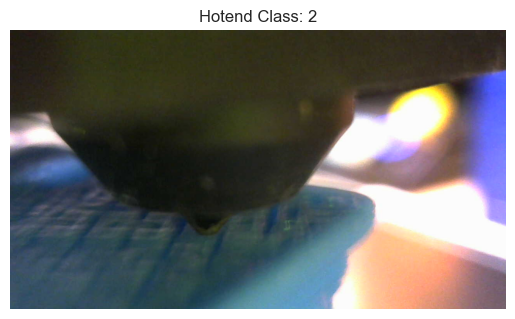

Attempting to open: 'C:\\Users\\Sandhra George\\avalanche\\caxton_dataset\\print132\\image-4013.jpg'


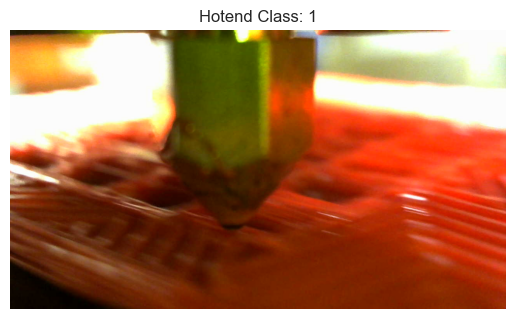

Attempting to open: 'C:\\Users\\Sandhra George\\avalanche\\caxton_dataset\\print132\\image-4307.jpg'


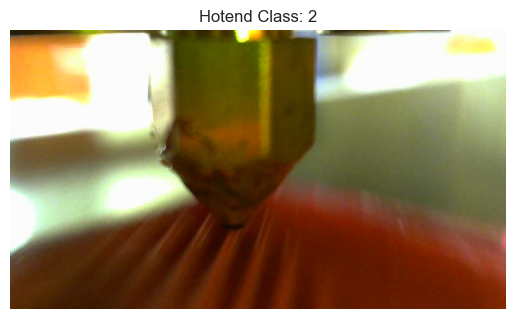

Attempting to open: 'C:\\Users\\Sandhra George\\avalanche\\caxton_dataset\\print46\\image-6431.jpg'


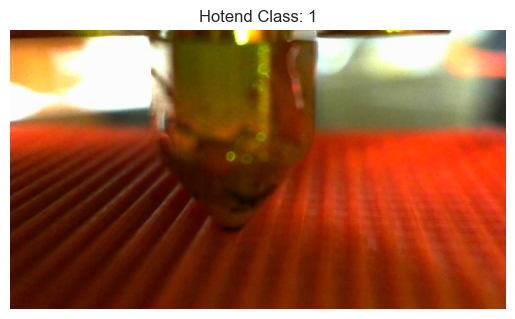

Attempting to open: 'C:\\Users\\Sandhra George\\avalanche\\caxton_dataset\\print109\\image-2051.jpg'


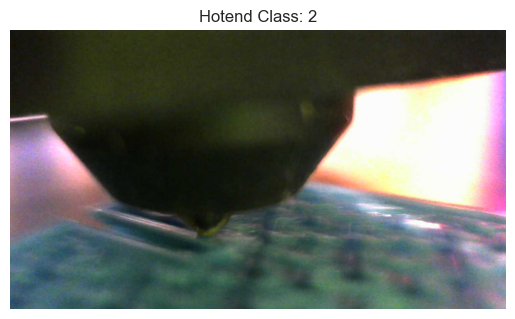

Displaying 5 random images from: Experience 1_2 Train Dataset - Subdataset 1
Attempting to open: 'C:\\Users\\Sandhra George\\avalanche\\caxton_dataset\\print132\\image-9842.jpg'


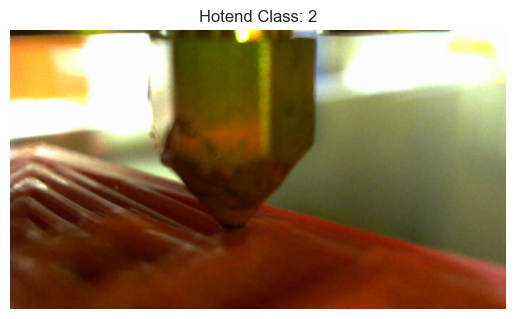

Attempting to open: 'C:\\Users\\Sandhra George\\avalanche\\caxton_dataset\\print46\\image-9770.jpg'


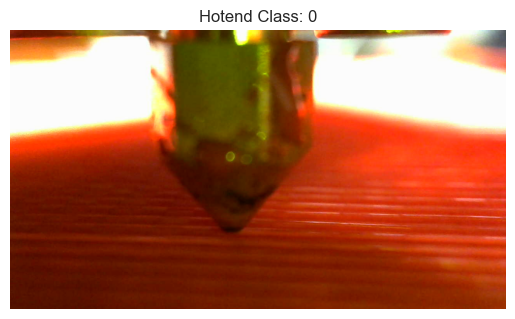

Attempting to open: 'C:\\Users\\Sandhra George\\avalanche\\caxton_dataset\\print132\\image-19951.jpg'


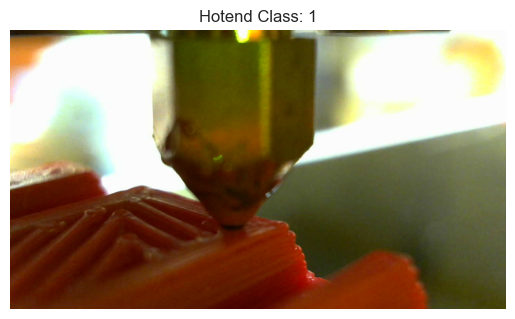

Attempting to open: 'C:\\Users\\Sandhra George\\avalanche\\caxton_dataset\\print82\\image-1433.jpg'


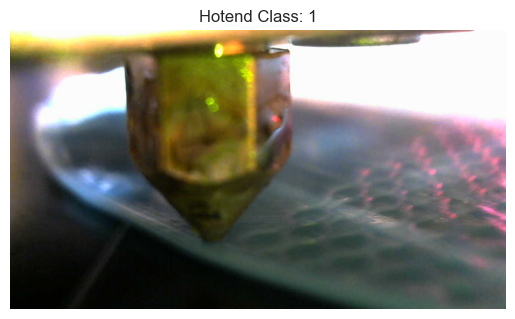

Attempting to open: 'C:\\Users\\Sandhra George\\avalanche\\caxton_dataset\\print24\\image-22949.jpg'


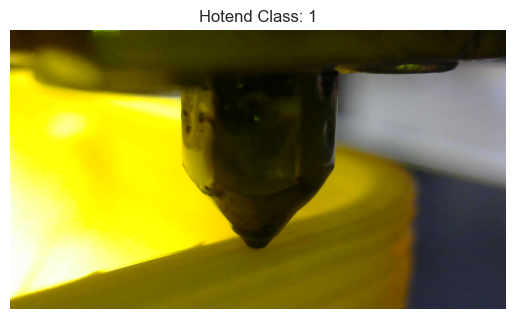

Dataset 'Experience 1_2 Valid Dataset' is a ConcatDataset; iterating through sub-datasets...
Displaying 5 random images from: Experience 1_2 Valid Dataset - Subdataset 0
Attempting to open: 'C:\\Users\\Sandhra George\\avalanche\\caxton_dataset\\print109\\image-24725.jpg'


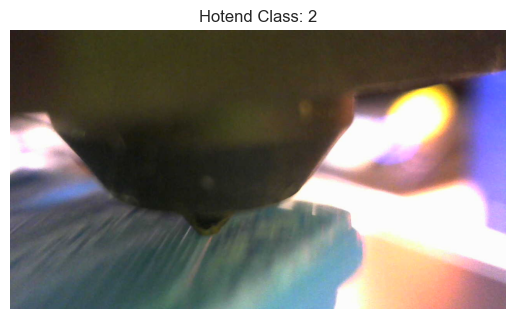

Attempting to open: 'C:\\Users\\Sandhra George\\avalanche\\caxton_dataset\\print24\\image-7150.jpg'


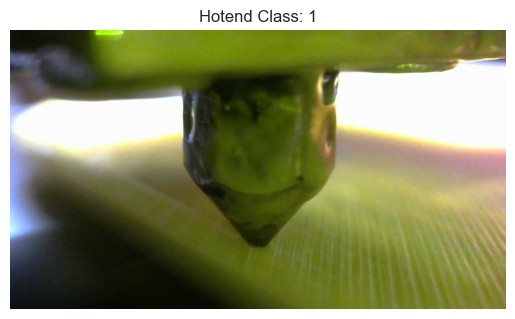

Attempting to open: 'C:\\Users\\Sandhra George\\avalanche\\caxton_dataset\\print132\\image-20563.jpg'


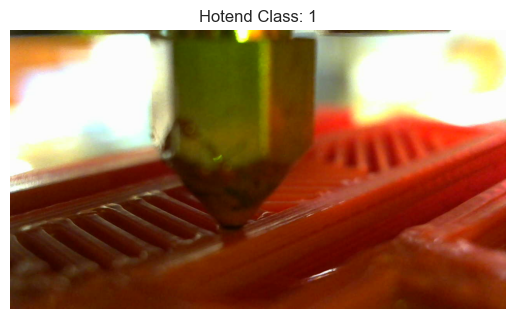

Attempting to open: 'C:\\Users\\Sandhra George\\avalanche\\caxton_dataset\\print111\\image-12576.jpg'


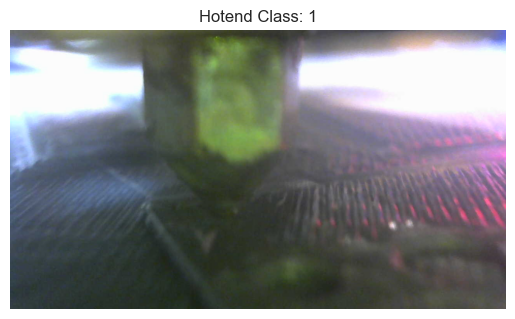

Attempting to open: 'C:\\Users\\Sandhra George\\avalanche\\caxton_dataset\\print24\\image-16560.jpg'


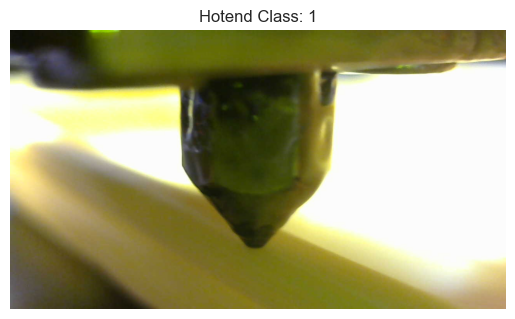

Displaying 5 random images from: Experience 1_2 Valid Dataset - Subdataset 1
Attempting to open: 'C:\\Users\\Sandhra George\\avalanche\\caxton_dataset\\print109\\image-7616.jpg'


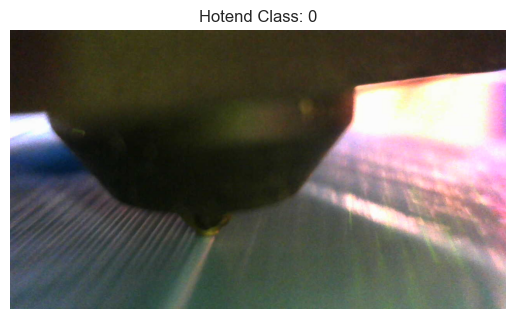

Attempting to open: 'C:\\Users\\Sandhra George\\avalanche\\caxton_dataset\\print46\\image-7756.jpg'


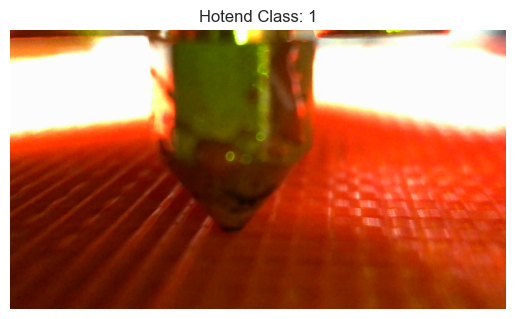

Attempting to open: 'C:\\Users\\Sandhra George\\avalanche\\caxton_dataset\\print82\\image-23089.jpg'


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x000001C1ADCBB110>>
Traceback (most recent call last):
  File "C:\Users\Sandhra George\avalanche\venv\Lib\site-packages\ipykernel\ipkernel.py", line 790, in _clean_thread_parent_frames
    active_threads = {thread.ident for thread in threading.enumerate()}
                                                 ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Sandhra George\AppData\Local\Programs\Python\Python312\Lib\threading.py", line 1535, in enumerate
    def enumerate():
    
KeyboardInterrupt: 


KeyboardInterrupt: 

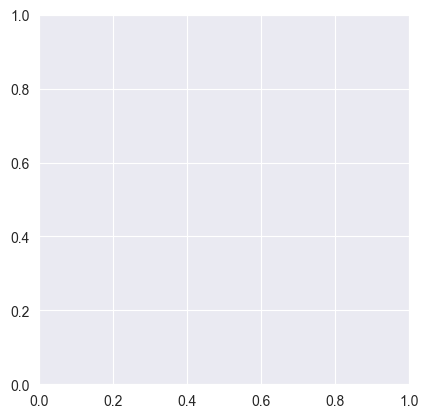

In [52]:
import random
import os
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import ConcatDataset

def display_random_images(dataset, dataset_name, num_images=5, root_folder=r"C:\Users\Sandhra George\avalanche\caxton_dataset"):
    """
    Display num_images random images from the given dataset along with their hotend class labels.
    
    If the underlying DataFrame has 2 columns:
      - Column 0: relative image path (e.g., "print46/image-8719.jpg")
      - Column 1: hotend class label
    If the DataFrame has 3 (or more) columns, it ignores the first column and uses:
      - Column 1: relative image path
      - Column 2: hotend class label
    
    The full image path is constructed as:
         root_folder/<relative image path>
    
    If the dataset is a ConcatDataset, the function iterates over its sub-datasets.
    """
    
    if hasattr(dataset, 'data'):
        cols = dataset.data.shape[1]
        if cols == 2:
            # Structure: [image_path, hotend_label]
            get_img_path = lambda row: row[0]
            get_label   = lambda row: row[1]
        elif cols >= 3:
            # Structure: [extra, image_path, hotend_label, ...] – ignore the first column
            get_img_path = lambda row: row[1]
            get_label   = lambda row: row[2]
        else:
            print(f"Dataset {dataset_name} does not have enough columns (got {cols}).")
            return

        print(f"Displaying {num_images} random images from: {dataset_name}")
        sample_indices = random.sample(range(len(dataset.data)), num_images)
        for idx in sample_indices:
            row = dataset.data.iloc[idx]
            # Clean the strings: remove extra spaces and ensure correct separator
            img_rel_path = str(get_img_path(row)).strip().replace("/", os.path.sep)
            label = str(get_label(row)).strip()
            full_path = os.path.join(root_folder, img_rel_path)
            
            # Debug print: print the full path with repr to reveal any hidden characters
            print(f"Attempting to open: {repr(full_path)}")
            
            if not os.path.exists(full_path):
                print(f"File does not exist: {repr(full_path)}")
                continue
            
            try:
                img = Image.open(full_path)
            except Exception as e:
                print(f"Error opening {full_path}: {e}")
                continue

            plt.figure()
            plt.imshow(img)
            plt.title(f"Hotend Class: {label}")
            plt.axis("off")
            plt.show()

    elif isinstance(dataset, ConcatDataset):
        print(f"Dataset '{dataset_name}' is a ConcatDataset; iterating through sub-datasets...")
        for i, subdataset in enumerate(dataset.datasets):
            display_random_images(subdataset, f"{dataset_name} - Subdataset {i}", num_images, root_folder)
    else:
        print("Unsupported dataset type:", type(dataset))

# Example usage:
display_random_images(exp1_train, "Experience 1 Train Dataset")
display_random_images(exp1_valid, "Experience 1 Valid Dataset")
display_random_images(exp1_test, "Experience 1 Test Dataset")

display_random_images(exp1_2_train, "Experience 1_2 Train Dataset")
display_random_images(exp1_2_valid, "Experience 1_2 Valid Dataset")
display_random_images(exp1_2_test, "Experience 1_2 Test Dataset")

display_random_images(exp1_2_3_train, "Experience 1_2_3 Train Dataset")
display_random_images(exp1_2_3_valid, "Experience 1_2_3 Valid Dataset")
display_random_images(exp1_2_3_test, "Experience 1_2_3 Test Dataset")

## Benchmark experiment 

In [ ]:
import os
import csv
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from torch.utils.data import DataLoader, ConcatDataset
from torchmetrics import ConfusionMatrix
from models.cnn_models import SimpleCNN
from sklearn.metrics import confusion_matrix

# Define the experiment configurations in a dictionary.
experiments = {
    "experience_1": (exp1_train, exp1_valid, exp1_test),
    "experience_1_2": (exp1_2_train, exp1_2_valid, exp1_2_test),
    "experience_1_2_3": (exp1_2_3_train, exp1_2_3_valid, exp1_2_3_test)
}

# Create a mapping between experiment names and your new DataLoader variables.
# (Make sure these variables are already created: exp1_train_loader, exp1_valid_loader, etc.)
# For example:
#   "experience_1" --> exp1_train_loader, exp1_valid_loader, exp1_test_loader
#   "experience_1_2" --> exp1_2_train_loader, exp1_2_valid_loader, exp1_2_test_loader
#   "experience_1_2_3" --> exp1_2_3_train_loader, exp1_2_3_valid_loader, exp1_2_3_test_loader

# Get the current working directory and define the benchmark folder.
current_dir = os.getcwd()
benchmark_folder = os.path.join(current_dir, "benchmark_experiment_increased_data")
os.makedirs(benchmark_folder, exist_ok=True)
print(f"Benchmark folder created at: {benchmark_folder}")

# Training settings
num_epochs = 30
num_classes = 3  # update if needed

# Loop over each experiment configuration.
for exp_name, _ in experiments.items():
    print(f"\nStarting experiment: {exp_name}\n")
    
    # Create a subfolder for this experiment.
    exp_folder = os.path.join(benchmark_folder, exp_name)
    os.makedirs(exp_folder, exist_ok=True)
    
    # Set the best model path.
    best_model_path = os.path.join(exp_folder, f"model_{exp_name}.pth")
    
    # Retrieve the appropriate pre-created DataLoaders.
    if exp_name == "experience_1":
        train_loader = exp1_train_loader
        val_loader = exp1_valid_loader
        test_loader = exp1_test_loader
    elif exp_name == "experience_1_2":
        train_loader = exp1_2_train_loader
        val_loader = exp1_2_valid_loader
        test_loader = exp1_2_test_loader
    elif exp_name == "experience_1_2_3":
        train_loader = exp1_2_3_train_loader
        val_loader = exp1_2_3_valid_loader
        test_loader = exp1_2_3_test_loader
    else:
        raise ValueError(f"Unknown experiment name: {exp_name}")
    
    # Set device to GPU if available.
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Initialize model, loss function, optimizer, and scheduler.
    model = SimpleCNN(num_classes=num_classes).to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    
    # Initialize confusion matrix trackers.
    train_cm = ConfusionMatrix(task='multiclass', num_classes=num_classes).to(device)
    val_cm = ConfusionMatrix(task='multiclass', num_classes=num_classes).to(device)
    
    # For plotting losses and accuracies.
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    # Create CSV file to store epoch losses and accuracies.
    csv_file_path = os.path.join(exp_folder, "training_validation_losses.csv")
    header = ["Epoch", "Training Loss", "Training Accuracy", "Validation Loss", "Validation Accuracy"]
    if not os.path.exists(csv_file_path):
        with open(csv_file_path, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(header)
    
    best_val_accuracy = 0.0
    start_epoch = 0  # always start fresh for each experiment
    
    # ----------------- Training and Validation Loop -----------------
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        model.train()  # Set model to training mode
        
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        class_counts = [0] * num_classes
        
        # Training phase with progress bar.
        for images, labels in tqdm(train_loader, desc="Training", leave=False):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            #print(f"Outputs (Raw): {outputs}")  # Log raw outputs
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            
            # Update confusion matrix and class counts.
            train_cm.update(predicted, labels)
            for label in labels:
                class_counts[label.item()] += 1
                
            # Print predicted vs actual labels for each batch.
            #for i in range(len(labels)):
                #print(f"Predicted: {predicted[i].item()}, Actual: {labels[i].item()}")
        
        train_epoch_loss = running_loss / total_samples
        train_epoch_accuracy = correct_predictions / total_samples
        print(f"Training Loss: {train_epoch_loss:.4f}, Training Accuracy: {train_epoch_accuracy:.4f}")
        print(f"Training Class Distribution: {class_counts}")
        
        # Update learning rate scheduler.
        scheduler.step()
        train_losses.append(train_epoch_loss)
        train_accuracies.append(train_epoch_accuracy)
        
        # Compute and save training confusion matrix.
        cm_train = train_cm.compute()
        print(f"Training Confusion Matrix:\n{cm_train}")
        sns.heatmap(cm_train.cpu().numpy(), annot=True, fmt="d", cmap="Blues",
                    xticklabels=range(num_classes), yticklabels=range(num_classes))
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'Training Confusion Matrix - Epoch {epoch + 1}')
        output_path_train = os.path.join(exp_folder, f"training_confusion_matrix_epoch_{epoch + 1}.png")
        plt.savefig(output_path_train)
        plt.clf()  # Clear the plot
        print(f"Training Confusion Matrix saved to: {output_path_train}")
        train_cm.reset()
        
        # ----------------- Validation Phase -----------------
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        val_correct_predictions = 0
        val_total_samples = 0
        val_class_counts = [0] * num_classes
        
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validating", leave=False):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                #print(f"Outputs (Raw): {outputs}")  # Log raw outputs
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct_predictions += (predicted == labels).sum().item()
                val_total_samples += labels.size(0)
                
                val_cm.update(predicted, labels)
                for label in labels:
                    val_class_counts[label.item()] += 1
                
                #for i in range(len(labels)):
                    #print(f"Predicted: {predicted[i].item()}, Actual: {labels[i].item()}")
        
        val_epoch_loss = val_loss / val_total_samples
        val_epoch_accuracy = val_correct_predictions / val_total_samples
        print(f"Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_accuracy:.4f}")
        print(f"Validation Class Distribution: {val_class_counts}")
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_accuracy)
        
        cm_val = val_cm.compute()
        print(f"Validation Confusion Matrix:\n{cm_val}")
        sns.heatmap(cm_val.cpu().numpy(), annot=True, fmt="d", cmap="Blues",
                    xticklabels=range(num_classes), yticklabels=range(num_classes))
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'Validation Confusion Matrix - Epoch {epoch + 1}')
        output_path_val = os.path.join(exp_folder, f"validation_confusion_matrix_epoch_{epoch + 1}.png")
        plt.savefig(output_path_val)
        plt.clf()
        print(f"Validation Confusion Matrix saved to: {output_path_val}")
        val_cm.reset()
        
        # Save the best model if validation accuracy improves.
        if val_epoch_accuracy > best_val_accuracy:
            best_val_accuracy = val_epoch_accuracy
            torch.save({
                "epoch": epoch + 1,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "scheduler_state": scheduler.state_dict(),
                "best_val_accuracy": best_val_accuracy
            }, best_model_path)
            print(f"Saved best model for {exp_name} at epoch {epoch + 1} with accuracy {best_val_accuracy:.4f}")
        
        # Append losses and accuracies to CSV.
        with open(csv_file_path, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([epoch + 1, train_epoch_loss, train_epoch_accuracy, val_epoch_loss, val_epoch_accuracy])
    
    print(f"Experiment {exp_name} training complete. Losses saved to: {csv_file_path}")
    
    # ----------------- Testing Phase -----------------
    def test_model(model, test_loader):
        model.eval()
        correct_predictions = 0
        total_samples = 0
        test_class_counts = [0] * num_classes
        all_labels = []
        all_predictions = []
        with torch.no_grad():
            for images, labels in tqdm(test_loader, desc="Testing", leave=False):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                correct_predictions += (predicted == labels).sum().item()
                total_samples += labels.size(0)
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
                for label in labels:
                    test_class_counts[label.item()] += 1
                #for i in range(len(labels)):
                    #print(f"Predicted: {predicted[i].item()}, Actual: {labels[i].item()}")
        avg_accuracy = correct_predictions / total_samples
        print(f"Test Accuracy: {avg_accuracy:.4f}")
        print(f"Test Class Distribution: {test_class_counts}")
        
        from sklearn.metrics import confusion_matrix
        cm_test = confusion_matrix(all_labels, all_predictions, labels=list(range(num_classes)))
        print(f"Test Confusion Matrix:\n{cm_test}")
        
        sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues",
                    xticklabels=range(num_classes), yticklabels=range(num_classes))
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Test Confusion Matrix')
        output_path_test = os.path.join(exp_folder, "test_confusion_matrix.png")
        plt.savefig(output_path_test)
        plt.clf()
        print(f"Test Confusion Matrix saved to: {output_path_test}")
    
    test_model(model, test_loader)
    
    # Plot the training and validation losses.
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='blue')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Losses for {exp_name}')
    plt.legend()
    plt.grid(True)
    loss_plot_path = os.path.join(exp_folder, "training_validation_loss.png")
    plt.savefig(loss_plot_path)
    plt.clf()
    print(f"Training and Validation Loss plot saved to: {loss_plot_path}")
    
    # Plot the training and validation accuracies.
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy', color='blue')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'Training and Validation Accuracies for {exp_name}')
    plt.legend()
    plt.grid(True)
    accuracy_plot_path = os.path.join(exp_folder, "training_validation_accuracy.png")
    plt.savefig(accuracy_plot_path)
    plt.clf()
    print(f"Training and Validation Accuracy plot saved to: {accuracy_plot_path}")

print("\nAll benchmark experiments completed.")

## Checking image and label alignment